In [3]:
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# for splitting training, validation and test set
from sklearn.model_selection import train_test_split

# mathplot lib
from matplotlib import pyplot as plt
from sklearn.utils import class_weight as cw

# contains randAugmentation, cutMix and MixUp
from keras_cv import layers as kcvl


from tqdm import tqdm 

np.random.seed(6)
tf.random.set_seed(6);

# **IMPORT DATA**

In [4]:
file_path = "/kaggle/input/uniquedataset/uniqueDataset.npz"
data = np.load(file_path)
images = data['images']
labels = data['labels']

indices = np.random.permutation(len(images))

# Shuffle images and labels
images_shuffled = images[indices]
labels_shuffled = labels[indices]

# Controlla i primi batch
print("Immagini:", images.shape)
print("Etichette:", labels.shape)

labels = tf.keras.utils.to_categorical(labels, num_classes=8)

print("Images dtype before:", images.dtype)
print("Labels dtype after:", labels.dtype)

Immagini: (11953, 96, 96, 3)
Etichette: (11953, 1)
Images dtype before: uint8
Labels dtype after: float64


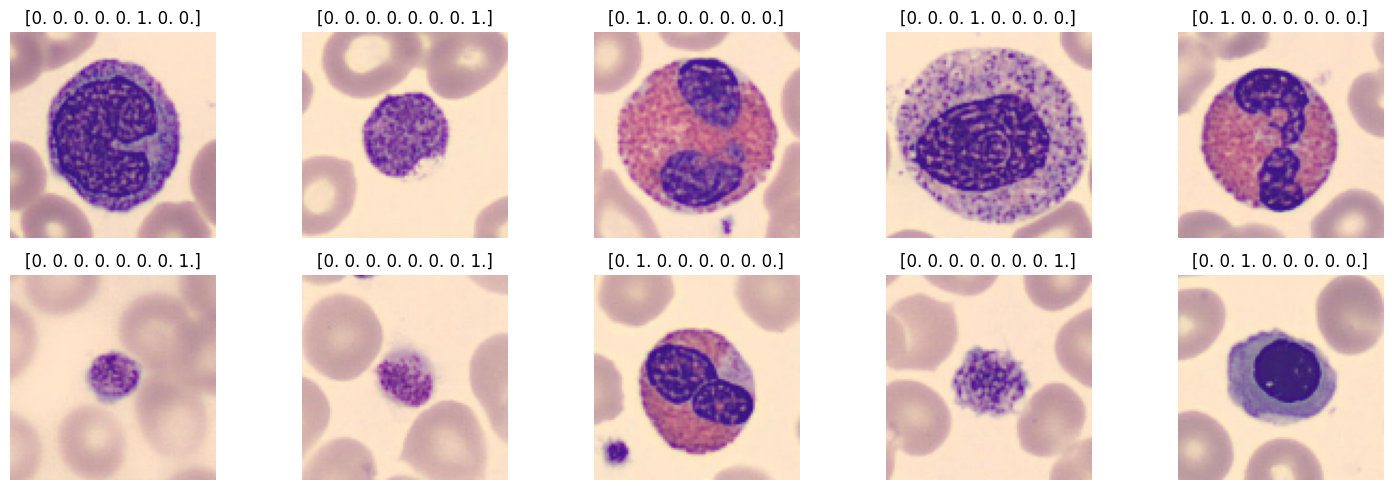

In [25]:
def show_random_samples(images, labels, num_samples=10):
    # Campiona casualmente gli indici
    indices = np.random.choice(len(images), num_samples, replace=False)
    sampled_images = images[indices]
    sampled_labels = labels[indices]

    # Plot delle immagini
    plt.figure(figsize=(15, 5))
    for i, (img, label) in enumerate(zip(sampled_images, sampled_labels)):
        plt.subplot(2, 5, i + 1)  # 2 righe x 5 colonne
        if img.shape[-1] == 1:  # Scala di grigi
            plt.imshow(img.squeeze(), cmap='gray')
        else:
            plt.imshow(img)
        label_truncated = np.floor(label * 100) / 100
        plt.title(f"{label_truncated}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Esempio di utilizzo
show_random_samples(images, labels)

# **ANALIZE DATA**

In [8]:
decoded_labels = np.argmax(labels, axis=1)  # Decode one-hot labels to class indices

unique_labels, label_counts = np.unique(decoded_labels, return_counts=True)

total_images = len(decoded_labels)  # Total number of images
num_classes = len(unique_labels)  # Number of classes

category_weight = {}

for i in range(num_classes):
    category_weight[unique_labels[i]] = total_images / (num_classes * label_counts[i])

print(category_weight)

{0: 1.7557285546415982, 1: 0.6856929784304727, 2: 1.377073732718894, 3: 0.7385689569945625, 4: 1.759864546525324, 5: 1.5046576032225578, 6: 0.641255364806867, 7: 0.909388314059647}


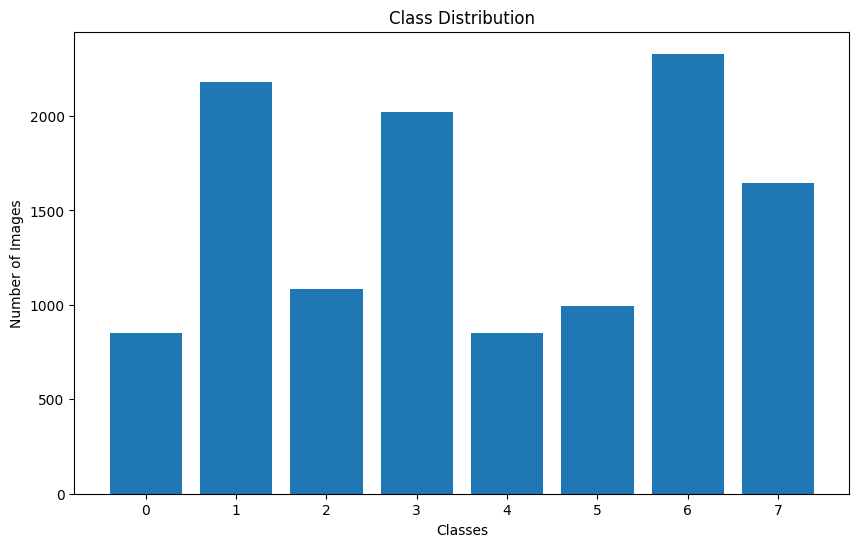

Class 0: 851 images (7.12%)
Class 1: 2179 images (18.23%)
Class 2: 1085 images (9.08%)
Class 3: 2023 images (16.92%)
Class 4: 849 images (7.10%)
Class 5: 993 images (8.31%)
Class 6: 2330 images (19.49%)
Class 7: 1643 images (13.75%)


In [9]:
# Assuming 'decoded_labels' contains the class indices (not one-hot encoded)
# and 'unique_labels' and 'label_counts' are already calculated as in the provided code.

plt.figure(figsize=(10, 6))
plt.bar(unique_labels, label_counts)
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.title("Class Distribution")
plt.xticks(unique_labels)  # Ensure all class labels are shown on the x-axis
plt.show()

# Print the class distribution in a more readable format.
for label, count in zip(unique_labels, label_counts):
    print(f"Class {label}: {count} images ({count / total_images * 100:.2f}%)")

# **SPLIT DATA**

In [14]:
X_train, X_val_test, y_train, y_val_test = train_test_split(
    images, labels, test_size=0.405, stratify=labels, random_state=42
)

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val_test shape: {X_val_test.shape}, y_val shape: {y_val_test.shape}")

X_train shape: (7112, 96, 96, 3), y_train shape: (7112, 8)
X_val_test shape: (4841, 96, 96, 3), y_val shape: (4841, 8)


In [15]:
X_val, X_test, y_val, y_test = train_test_split(
    X_val_test, y_val_test, test_size=0.1, stratify=y_val_test, random_state=42
)

# Print shapes of the datasets
print(f"X_val shape: {X_val.shape}, y_train shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_val shape: {y_test.shape}")

X_val shape: (4356, 96, 96, 3), y_train shape: (4356, 8)
X_test shape: (485, 96, 96, 3), y_val shape: (485, 8)


# **TRAIN STATIC AUGMENTATION**

In [16]:
# Convert to Tensor (this is usefull if we need to transform the images with cutMix and mixUp)
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)

# Hyperparameters
batch_size = 512  # Processa i dati in batch
cutMix = True
mixUp = True
randAugment = True
cutOut = True
splitRotate= True

# Placeholder per immagini e etichette aumentate
X_augmented = []
y_augmented = []

# Funzione per processare in batch
def process_batches(X, y, augmenter, augment_labels=True):
    X_aug = []
    y_aug = []
    
    for i in tqdm (range(0, len(X), batch_size)):
        
        X_batch = X[i:i + batch_size]
        y_batch = y[i:i + batch_size]
        
        # Applica l'augmentazione
        temp = augmenter({"images": X_batch, "labels": y_batch})
        temp_images = tf.image.resize(temp["images"], [96, 96]).numpy()
        
        if augment_labels:
            temp_labels = temp["labels"].numpy()
        else:
            temp_labels = y_batch.numpy()
        
        X_aug.append(temp_images)
        y_aug.append(temp_labels)
    
    return np.concatenate(X_aug, axis=0), np.concatenate(y_aug, axis=0)


def apply_cutOut(X_train, mask_size=(32, 32)):
    
    def cutout(image, mask_size):
        h, w, _ = image.shape
        mask_h, mask_w = mask_size
    
        # Scegli la posizione casuale dove applicare la maschera
        top_left_x = np.random.randint(0, w - mask_w)
        top_left_y = np.random.randint(0, h - mask_h)
    
        # Applicare la maschera (pixel neri)
        image[top_left_y:top_left_y + mask_h, top_left_x:top_left_x + mask_w] = 0
    
        return image
    
    augmented_images = []
    
    for image in X_train:
        # Crea una copia dell'immagine per evitare di modificarla direttamente
        augmented_image = image.copy()
        
        # Applicare CutOut sull'immagine
        augmented_image = cutout(augmented_image, mask_size)
        
        # Aggiungere l'immagine aumentata alla lista
        augmented_images.append(augmented_image)
    
    # Converti la lista di immagini in un array numpy
    augmented_images = np.array(augmented_images)
    
    return augmented_images


def split_rotate(X_train, target_size=(96, 96)):
    def rotate_image(image, angle):
        if angle == 90:
            return np.rot90(image, k=1)
        elif angle == 180:
            return np.rot90(image, k=2)
        elif angle == 270:
            return np.rot90(image, k=3)
        else:
            return image
            
    augmented_images = []
    
    for image in X_train:
        # Dividere l'immagine in 4 quadranti
        height, width, _ = image.shape
        top_left = image[:height//2, :width//2]
        top_right = image[:height//2, width//2:]
        bottom_left = image[height//2:, :width//2]
        bottom_right = image[height//2:, width//2:]
        
        # Ruotare i quadranti separatamente
        angles = np.random.choice([0, 90, 180, 270], size=4)
        rotated_top_left = rotate_image(top_left, angles[0])
        rotated_top_right = rotate_image(top_right, angles[1])
        rotated_bottom_left = rotate_image(bottom_left, angles[2])
        rotated_bottom_right = rotate_image(bottom_right, angles[3])
        
        # Ricomporre l'immagine intera con i quadranti ruotati
        top_half = np.concatenate([rotated_top_left, rotated_top_right], axis=1)
        bottom_half = np.concatenate([rotated_bottom_left, rotated_bottom_right], axis=1)
        final_image = np.concatenate([top_half, bottom_half], axis=0)
        
        # Ridimensionare l'immagine finale per assicurarsi che abbia la forma desiderata
        resized_final_image = np.resize(final_image, target_size + (image.shape[2],)) if len(final_image.shape) == 3 else np.resize(final_image, target_size)
        
        # Aggiungere l'immagine finale alla lista
        augmented_images.append(resized_final_image)
    
    # Converti la lista di immagini in un array numpy
    augmented_images = np.array(augmented_images)
    
    return augmented_images

# Applica CutMix
if cutMix:
    cutmix = kcvl.CutMix(alpha=0.9)
    X_temp, y_temp = process_batches(X_train_tensor, y_train_tensor, cutmix)
    X_augmented.append(X_temp)
    y_augmented.append(y_temp)

# Applica MixUp
if mixUp:
    mixup = kcvl.MixUp(alpha=0.9)
    X_temp, y_temp = process_batches(X_train_tensor, y_train_tensor, mixup)
    X_augmented.append(X_temp)
    y_augmented.append(y_temp)

if cutOut:
    X_temp = []
    for i in tqdm( range(0, len(X_train), batch_size)):
        X_batch = X_train[i:i + batch_size]
        temp_images = apply_cutOut(X_batch)
        X_temp.append(temp_images)
    X_augmented.append(np.concatenate(X_temp, axis=0))
    y_augmented.append(y_train)  # CutOut preserva le etichette

if splitRotate:
    X_temp = []
    for i in tqdm( range(0, len(X_train), batch_size)):
        X_batch = X_train[i:i + batch_size]
        temp_images = split_rotate(X_batch)
        X_temp.append(temp_images)
    X_augmented.append(np.concatenate(X_temp, axis=0))
    y_augmented.append(y_train)  # SplitRotate preserva le etichette

# Applica RandAugment
if randAugment:
    rand_augment = kcvl.RandAugment(
        value_range=(0, 255),
        augmentations_per_image=3,
        magnitude=0.2,
        magnitude_stddev=0.2,
        rate=1
    )
    X_temp = []
    for i in tqdm( range(0, len(X_train), batch_size)):
        X_batch = X_train[i:i + batch_size]
        temp_images = rand_augment(X_batch).numpy()
        X_temp.append(temp_images)
    X_augmented.append(np.concatenate(X_temp, axis=0))
    y_augmented.append(y_train)  # RandAugment preserva le etichette
    

# Combina i dataset aumentati
X_augmented = np.concatenate(X_augmented, axis=0)
y_augmented = np.concatenate(y_augmented, axis=0)

# Concatenazione finale
X_train = np.concatenate((X_train, X_augmented), axis=0)
y_train = np.concatenate((y_train, y_augmented), axis=0)

print ("Train Images Shape:", X_train.shape)
print ("Train Labels Shape:", y_train.shape)

100%|██████████| 14/14 [05:17<00:00, 22.65s/it]


Train Images Shape: (42672, 96, 96, 3)
Train Labels Shape: (42672, 8)


# **VALIDATION STATIC AUGMENTATION**

In [17]:
rand_augment = kcvl.RandAugment(
        value_range=(0, 255),
        augmentations_per_image=5,
        magnitude=0.3,
        magnitude_stddev=0.3,
        rate=0.65)
X_val = np.array([rand_augment(image) for image in X_val])

print ("Val Images Shape:", X_val.shape)
print ("Val Labels Shape:", y_val.shape)

Val Images Shape: (4356, 96, 96, 3)
Val Labels Shape: (4356, 8)


# **DEBUGGING IMAGES AFTER AUGMENTATION**

Train Images


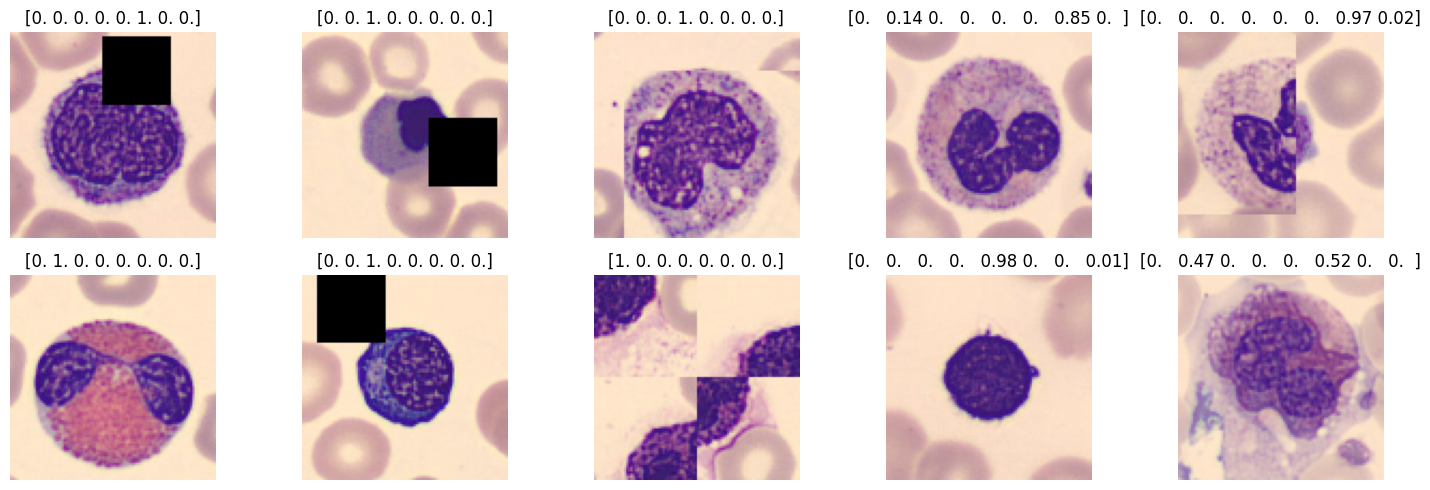

Val Images


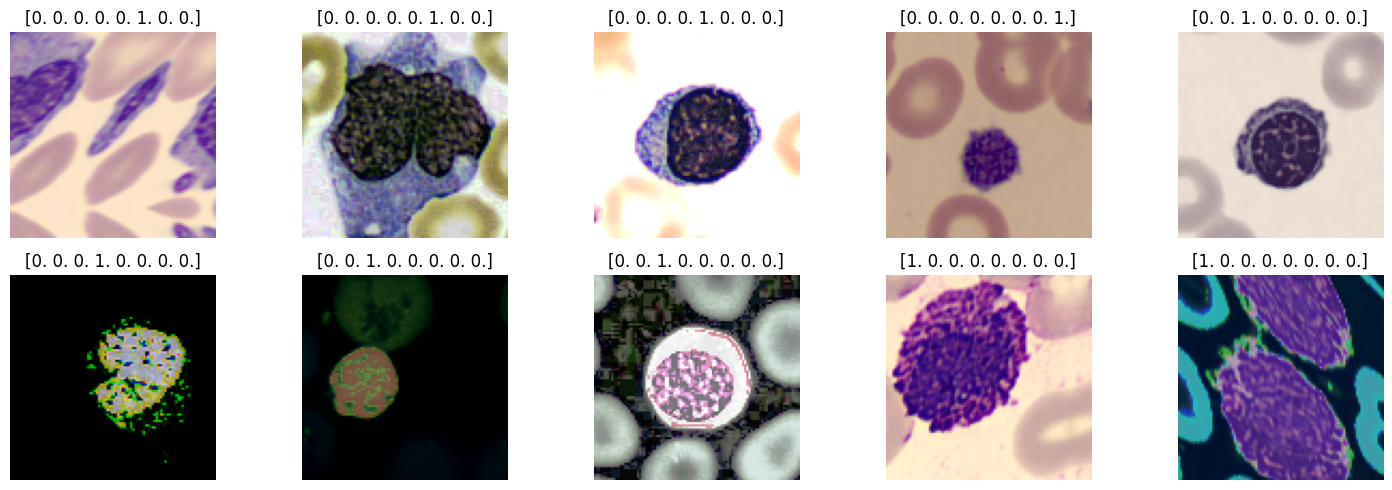

In [29]:
# We need to restore the form [0, 255] int otherwise we cannot print the images
X_train = np.clip(X_train, 0, 255).astype(np.uint8)
X_val = np.clip(X_val, 0, 255).astype(np.uint8)

print ("Train Images")
show_random_samples(X_train, y_train)

print ("Val Images")
show_random_samples(X_val, y_val)

# **MODEL**

In [37]:
# Define batch size, number of epochs, learning rate, input shape, and output shape
batch_size = 256
epochs = 121
input_shape = X_train.shape[1:]
output_shape = y_train.shape[-1]

# Print batch size, epochs, learning rate, input shape, and output shape
print(f"Batch Size: {batch_size}, Epochs: {epochs}")
print(f"Input Shape: {input_shape}, Output Shape: {output_shape}")

Batch Size: 256, Epochs: 121
Input Shape: (96, 96, 3), Output Shape: 8


In [43]:
gon = tfk.applications.ConvNeXtLarge(
    include_top=False,
    include_preprocessing=True,
    weights="imagenet",
    input_shape=(96,96,3),
    pooling='avg',
)
gon.trainable = False

785596384/785596384 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [44]:
# This method builds the model with given hyperparameters as inputs. The
# rationale behind the model is inside the report.

def build_model(fen, dropout_par, l_par, input_shape=input_shape, output_shape=output_shape):
  # Preprocessing
  inputs = tfkl.Input(shape=input_shape, name='Input')
    
  # FEN
  x = fen(inputs)
  x = tfkl.Dropout(dropout_par, name='dropout_0')(x)

  # First FC block
  x = tfkl.Dense(units=512, kernel_regularizer=tf.keras.regularizers.L1L2(l_par), kernel_initializer=tfk.initializers.HeUniform())(x)
  x = tfkl.BatchNormalization(name='batch_norm_1')(x)
  x = tfkl.Activation('relu', name='act_1')(x)
  x = tfkl.Dropout(dropout_par, name='dropout_1')(x)

  # Second FC block
  x = tfkl.Dense(units=256, kernel_regularizer=tf.keras.regularizers.L1L2(l_par), kernel_initializer=tfk.initializers.HeUniform())(x)
  x = tfkl.BatchNormalization(name='batch_norm_2')(x)
  x = tfkl.Activation('relu', name='act_2')(x)
  x = tfkl.Dropout(dropout_par, name='dropout_2')(x)

  # Third FC block
  x = tfkl.Dense(units=128, kernel_regularizer=tf.keras.regularizers.L1L2(l_par), kernel_initializer=tfk.initializers.HeUniform())(x)
  x = tfkl.BatchNormalization(name='batch_norm_3')(x)
  x = tfkl.Activation('relu', name='act_3')(x)
  x = tfkl.Dropout(dropout_par, name='dropout_3')(x)

  # Third FC block
  x = tfkl.Dense(units=64, kernel_regularizer=tf.keras.regularizers.L1L2(l_par), kernel_initializer=tfk.initializers.HeUniform())(x)
  x = tfkl.BatchNormalization(name='batch_norm_4')(x)
  x = tfkl.Activation('relu', name='act_4')(x)
  x = tfkl.Dropout(dropout_par, name='dropout_4')(x)

  # Fourth FC block
  x = tfkl.Dense(units=32, kernel_regularizer=tf.keras.regularizers.L1L2(l_par), kernel_initializer=tfk.initializers.HeUniform())(x)
  x = tfkl.BatchNormalization(name='batch_norm_5')(x)
  x = tfkl.Activation('relu', name='act_5')(x)
  x = tfkl.Dropout(dropout_par, name='dropout_5')(x)

  outputs = tfkl.Dense(output_shape, name='out', activation='softmax')(x)

  # Create a Model connecting input and output
  model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

  # Compile the model with Categorical Cross-Entropy loss and Nadam optimizer
  model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-3,weight_decay=1e-5), metrics=['accuracy'])

  # Display model summary
  model.summary()

  return model

In [45]:
gon = build_model(gon, 0.4, 1e-3, input_shape=(96,96,3), output_shape=8)

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convnext_large (Functional)     │ (None, 1536)           │   196,230,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_0 (Dropout)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_1                    │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act_1 (Activation)              │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_2                    │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act_2 (Activation)              │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_3                    │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act_3 (Activation)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_4                    │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act_4 (Activation)              │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_5                    │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act_5 (Activation)              │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 197,196,072 (752.24 MB)

 Trainable params: 963,752 (3.68 MB)

 Non-trainable params: 196,232,320 (748.57 MB)

In [46]:
from sklearn.utils.class_weight import compute_class_weight
# Calcola la distribuzione delle classi
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(np.argmax(y_train, axis=1)),  # Classi del train set
    y=np.argmax(y_train, axis=1)                   # Etichette come array 1D
)

# Convertilo in un dizionario
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Class Weights:", class_weight_dict)

sample_weights = []

for label in y_train:
    weight = sum(prob * class_weights[i] for i, prob in enumerate(label))  # Somma pesata per ogni classe
    sample_weights.append(weight)

sample_weights = np.array(sample_weights)

# Verifica la forma del vettore di sample weights
print("Sample Weights Array Shape:", sample_weights.shape)
print("Sample Weights Example:", sample_weights[15637:15658]) #check that the mixUp and cutMix correctly change the weights

Class Weights: {0: 1.7627230667547917, 1: 0.6900388098318241, 2: 1.3662909836065573, 3: 0.7424832962138085, 4: 1.7797797797797799, 5: 1.5, 6: 0.6425731839537405, 7: 0.8928690994308671}
Sample Weights Array Shape: (42672,)
Sample Weights Example: [0.8852326  1.35263312 1.76272307 0.65959738 0.68377419 0.70292986
 0.86283632 1.57186514 0.89708108 1.36773014 0.64257318 1.76272307
 1.27246467 1.36629098 1.20550372 0.80549876 1.6972929  1.22998877
 1.11833949 1.36474071 0.76109304]


In [47]:
# Train the model
tl_history = gon.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
    sample_weight = sample_weights,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=8, restore_best_weights=True),
                 tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=4, factor=0.2, min_lr=1e-8)]
).history

# Calculate and print the best validation accuracy achieved

final_val_accuracy = round(max(tl_history['val_accuracy']) * 100, 2)

print(f'Final validation accuracy: {final_val_accuracy}%')

Epoch 1/121


I0000 00:00:1732391209.414873     288 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_12', 1048 bytes spill stores, 1044 bytes spill loads

I0000 00:00:1732391209.466610     289 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_66', 1300 bytes spill stores, 1284 bytes spill loads



166/167 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2075 - loss: 26.4293

I0000 00:00:1732391429.963873     323 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_66', 1300 bytes spill stores, 1284 bytes spill loads

I0000 00:00:1732391431.118043     320 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_12', 1048 bytes spill stores, 1044 bytes spill loads



167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2079 - loss: 26.3786

I0000 00:00:1732391479.356362     351 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_6', 1744 bytes spill stores, 1748 bytes spill loads

I0000 00:00:1732391483.447278     351 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_12', 1048 bytes spill stores, 1044 bytes spill loads



167/167 ━━━━━━━━━━━━━━━━━━━━ 313s 2s/step - accuracy: 0.2084 - loss: 26.3286 - val_accuracy: 0.2470 - val_loss: 7.5688 - learning_rate: 0.0010
Epoch 2/121
167/167 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.4709 - loss: 5.8816 - val_accuracy: 0.1352 - val_loss: 4.3328 - learning_rate: 0.0010
Epoch 3/121
167/167 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.6317 - loss: 3.2306 - val_accuracy: 0.3242 - val_loss: 3.5826 - learning_rate: 0.0010
Epoch 4/121
167/167 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.6768 - loss: 2.8895 - val_accuracy: 0.6983 - val_loss: 2.8149 - learning_rate: 0.0010
Epoch 5/121
167/167 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.6960 - loss: 2.9081 - val_accuracy: 0.7670 - val_loss: 2.5729 - learning_rate: 0.0010
Epoch 6/121
167/167 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.7171 - loss: 2.7608 - val_accuracy: 0.7319 - val_loss: 2.5744 - learning_rate: 0.0010
Epoch 7/121
167/167 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.7350 - loss: 2.7212

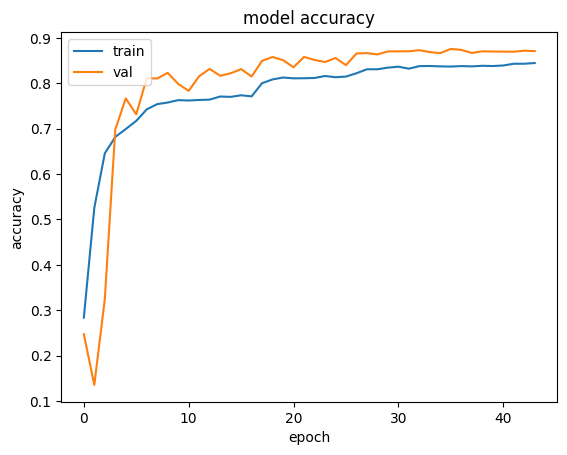

In [48]:
plt.plot(tl_history['accuracy'])
plt.plot(tl_history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [49]:
# Save the  model
gon.save('/kaggle/working/kite.keras')

I0000 00:00:1732400548.150988    1071 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_6', 1744 bytes spill stores, 1748 bytes spill loads

I0000 00:00:1732400548.787539    1073 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_12', 1048 bytes spill stores, 1044 bytes spill loads

I0000 00:00:1732400555.017288    1072 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_66', 1300 bytes spill stores, 1284 bytes spill loads



15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step

I0000 00:00:1732400572.306353    1094 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_12', 1048 bytes spill stores, 1044 bytes spill loads

I0000 00:00:1732400575.916541    1093 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_6', 1744 bytes spill stores, 1748 bytes spill loads



16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step 


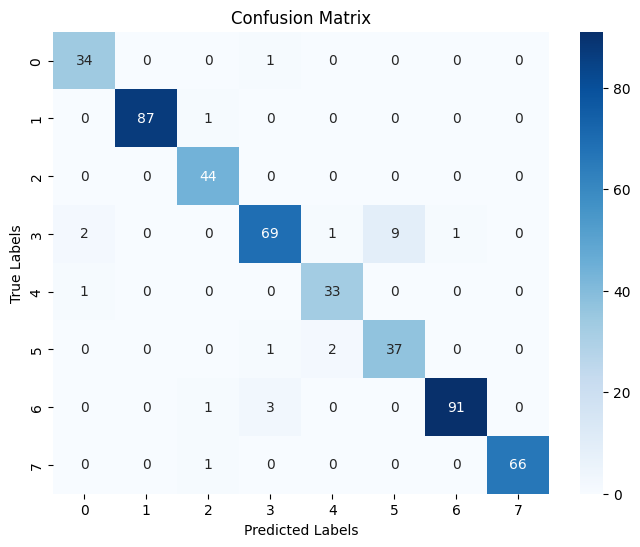

              precision    recall  f1-score   support

           0       0.92      0.97      0.94        35
           1       1.00      0.99      0.99        88
           2       0.94      1.00      0.97        44
           3       0.93      0.84      0.88        82
           4       0.92      0.97      0.94        34
           5       0.80      0.93      0.86        40
           6       0.99      0.96      0.97        95
           7       1.00      0.99      0.99        67

    accuracy                           0.95       485
   macro avg       0.94      0.96      0.94       485
weighted avg       0.95      0.95      0.95       485



In [50]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predict on the test set
y_pred = gon.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=np.arange(8), yticklabels=np.arange(8))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print(classification_report(y_true, y_pred_classes))

100%|██████████| 1/1 [00:20<00:00, 20.70s/it]


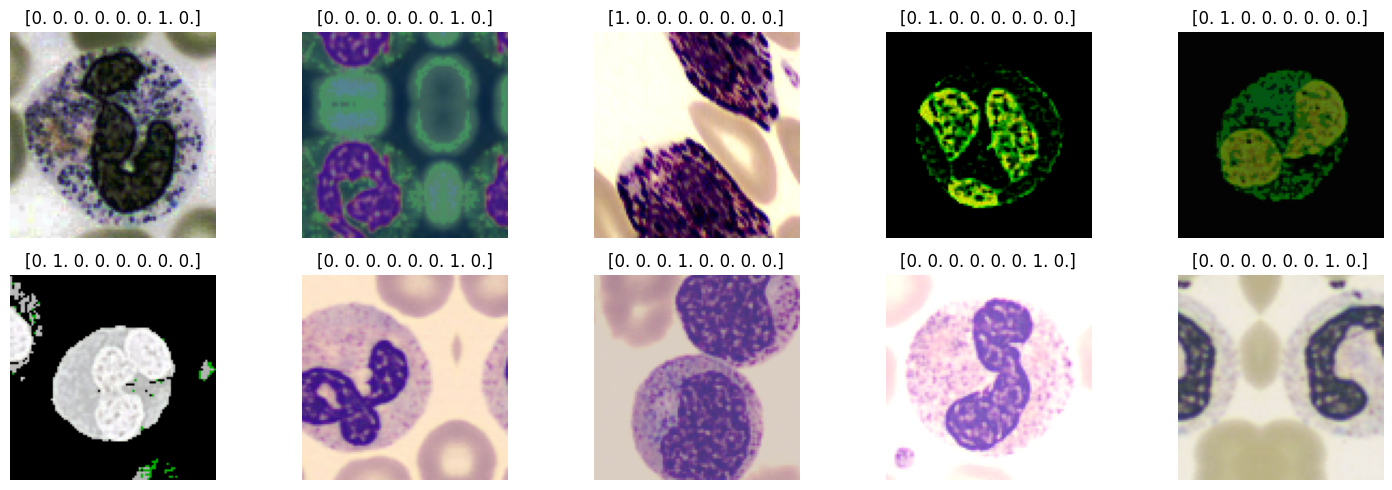

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step


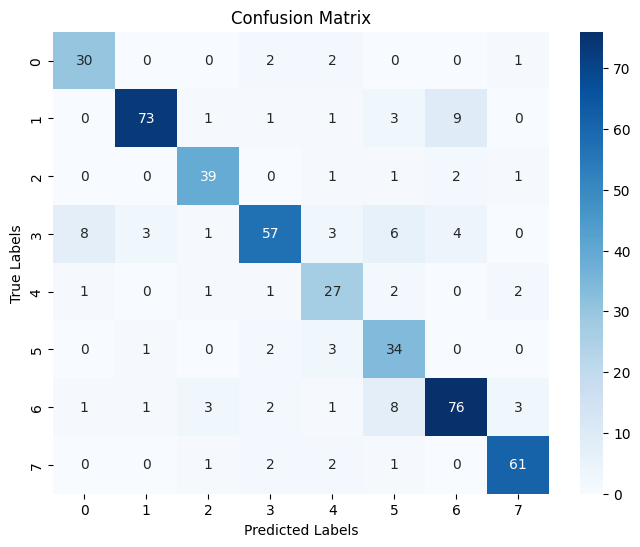

              precision    recall  f1-score   support

           0       0.75      0.86      0.80        35
           1       0.94      0.83      0.88        88
           2       0.85      0.89      0.87        44
           3       0.85      0.70      0.77        82
           4       0.68      0.79      0.73        34
           5       0.62      0.85      0.72        40
           6       0.84      0.80      0.82        95
           7       0.90      0.91      0.90        67

    accuracy                           0.82       485
   macro avg       0.80      0.83      0.81       485
weighted avg       0.83      0.82      0.82       485



In [51]:
rand_augment = kcvl.RandAugment(
        value_range=(0, 255),
        augmentations_per_image=4,
        magnitude=0.5,
        magnitude_stddev=0.5,
        rate=0.65
    )
X_test_aug = []
for i in tqdm( range(0, len(X_test), 512)):
    X_batch = X_test[i:i + 512]
    temp_images = rand_augment(X_batch).numpy()
    X_test_aug.append(temp_images)
X_test_aug = np.concatenate(X_test_aug, axis=0)

X_test_aug = np.clip(X_test_aug, 0, 255).astype(np.uint8)
show_random_samples(X_test_aug, y_test)


# Predict on the test set
y_pred = gon.predict(X_test_aug)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=np.arange(8), yticklabels=np.arange(8))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print(classification_report(y_true, y_pred_classes))

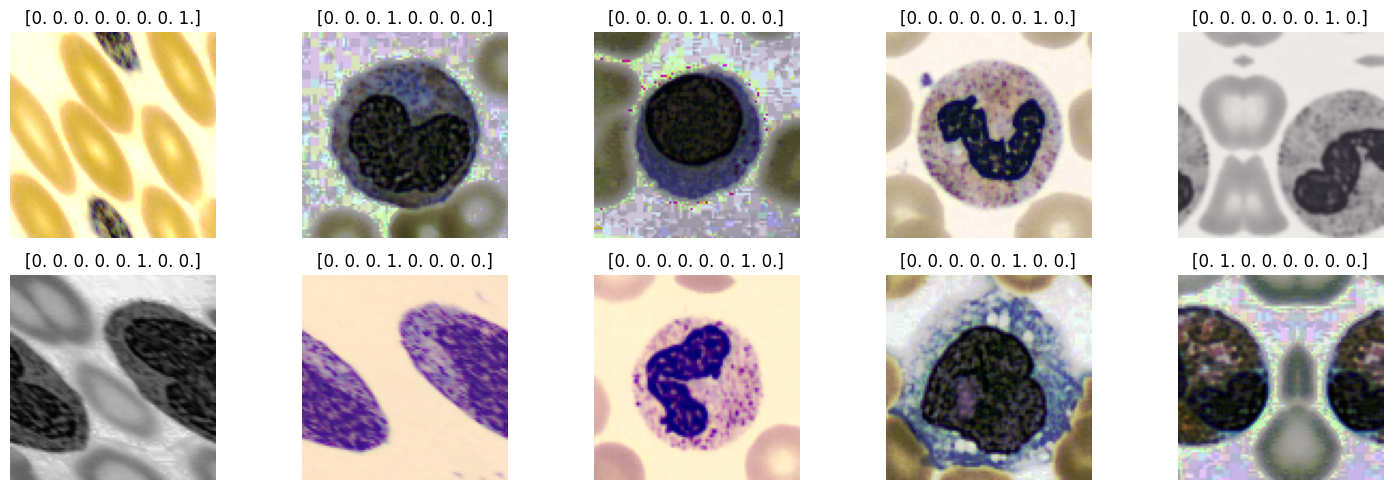

In [56]:
show_random_samples(X_test_aug, y_test)

# **FINE TUNING**

I0000 00:00:1732362569.747677     106 service.cc:145] XLA service 0x7fa0d00030c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732362569.747734     106 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732362569.747739     106 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1732362577.189151     136 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_66', 1300 bytes spill stores, 1284 bytes spill loads

I0000 00:00:1732362585.054425     138 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_12', 1032 bytes spill stores, 1032 bytes spill loads



 4/15 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step

I0000 00:00:1732362588.742828     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step

I0000 00:00:1732362600.312600     190 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_66', 1300 bytes spill stores, 1284 bytes spill loads

I0000 00:00:1732362606.633243     191 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_12', 1032 bytes spill stores, 1032 bytes spill loads



15/15 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step


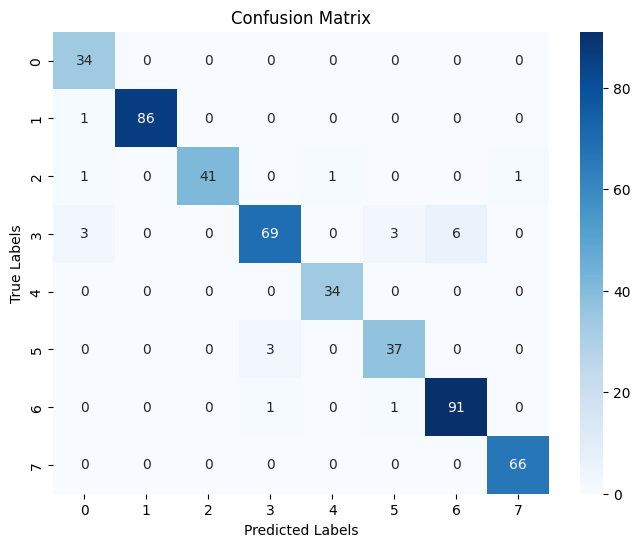

              precision    recall  f1-score   support

           0       0.87      1.00      0.93        34
           1       1.00      0.99      0.99        87
           2       1.00      0.93      0.96        44
           3       0.95      0.85      0.90        81
           4       0.97      1.00      0.99        34
           5       0.90      0.93      0.91        40
           6       0.94      0.98      0.96        93
           7       0.99      1.00      0.99        66

    accuracy                           0.96       479
   macro avg       0.95      0.96      0.95       479
weighted avg       0.96      0.96      0.96       479



In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predict on the test set
y_pred = gon.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=np.arange(8), yticklabels=np.arange(8))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print(classification_report(y_true, y_pred_classes))

100%|██████████| 1/1 [00:16<00:00, 16.39s/it]


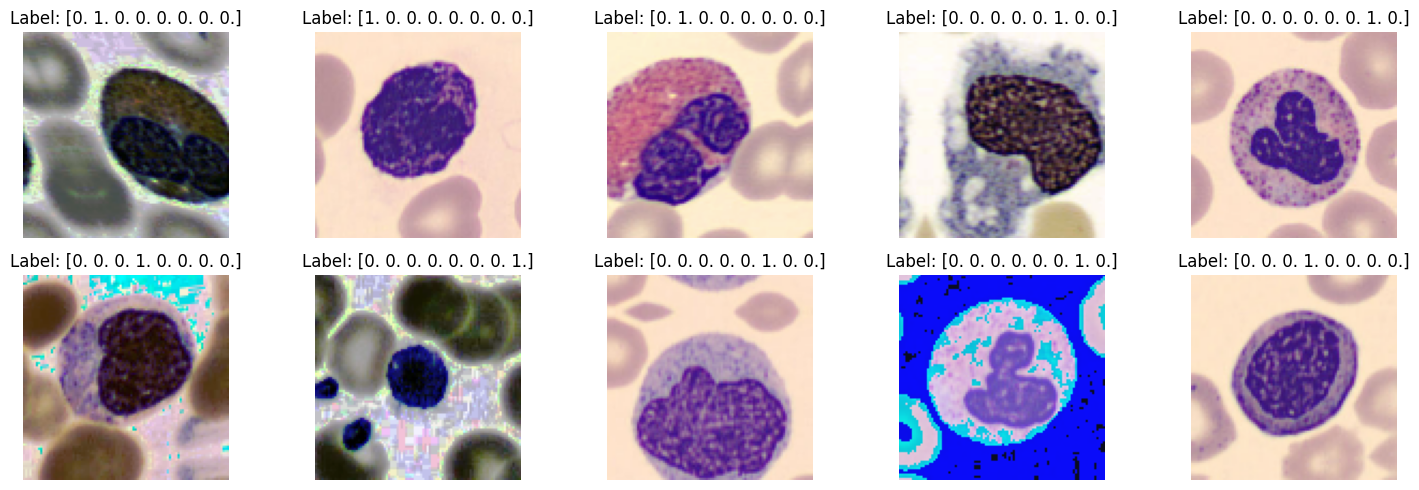

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


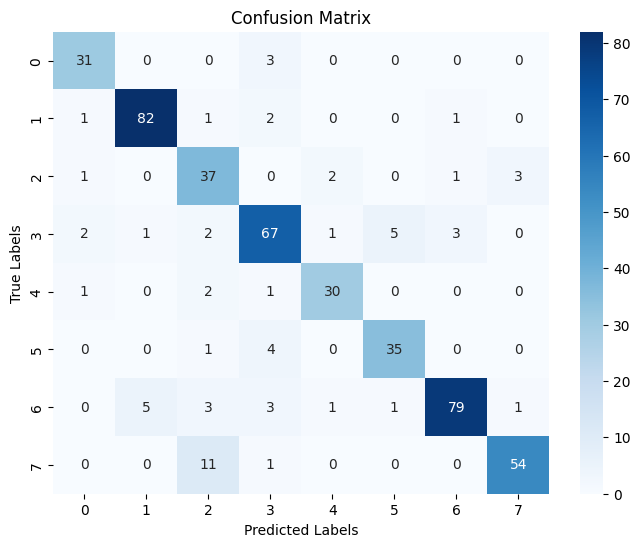

              precision    recall  f1-score   support

           0       0.86      0.91      0.89        34
           1       0.93      0.94      0.94        87
           2       0.65      0.84      0.73        44
           3       0.83      0.83      0.83        81
           4       0.88      0.88      0.88        34
           5       0.85      0.88      0.86        40
           6       0.94      0.85      0.89        93
           7       0.93      0.82      0.87        66

    accuracy                           0.87       479
   macro avg       0.86      0.87      0.86       479
weighted avg       0.87      0.87      0.87       479



In [15]:
rand_augment = kcvl.RandAugment(
        value_range=(0, 255),
        augmentations_per_image=4,
        magnitude=0.2,
        magnitude_stddev=0.2,
        rate=0.5
    )
X_test_aug = []
for i in tqdm( range(0, len(X_test), 512)):
    X_batch = X_test[i:i + 512]
    temp_images = rand_augment(X_batch).numpy()
    X_test_aug.append(temp_images)
X_test_aug = np.concatenate(X_test_aug, axis=0)

X_test_aug = np.clip(X_test_aug, 0, 255).astype(np.uint8)
show_random_samples(X_test_aug, y_test)


# Predict on the test set
y_pred = gon.predict(X_test_aug)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=np.arange(8), yticklabels=np.arange(8))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print(classification_report(y_true, y_pred_classes))

# **FINE TUNING**

In [52]:
gon_ft = tfk.models.load_model('/kaggle/working/kite.keras')
gon_ft.summary()

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convnext_large (Functional)     │ (None, 1536)           │   196,230,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_0 (Dropout)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_1                    │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act_1 (Activation)              │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_2                    │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act_2 (Activation)              │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_3                    │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act_3 (Activation)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_4                    │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act_4 (Activation)              │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_5                    │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act_5 (Activation)              │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 199,123,578 (759.60 MB)

 Trainable params: 963,752 (3.68 MB)

 Non-trainable params: 196,232,320 (748.57 MB)

 Optimizer params: 1,927,506 (7.35 MB)

In [57]:
gon_ft.get_layer('convnext_large').trainable = True
for i, layer in enumerate(gon_ft.get_layer('convnext_large').layers):
   print(i, layer.name, layer.trainable)

0 input_layer_10 True
1 convnext_large_prestem_normalization True
2 convnext_large_stem True
3 convnext_large_stage_0_block_0_depthwise_conv True
4 convnext_large_stage_0_block_0_layernorm True
5 convnext_large_stage_0_block_0_pointwise_conv_1 True
6 convnext_large_stage_0_block_0_gelu True
7 convnext_large_stage_0_block_0_pointwise_conv_2 True
8 convnext_large_stage_0_block_0_layer_scale True
9 convnext_large_stage_0_block_0_identity True
10 convnext_large_stage_0_block_1_depthwise_conv True
11 convnext_large_stage_0_block_1_layernorm True
12 convnext_large_stage_0_block_1_pointwise_conv_1 True
13 convnext_large_stage_0_block_1_gelu True
14 convnext_large_stage_0_block_1_pointwise_conv_2 True
15 convnext_large_stage_0_block_1_layer_scale True
16 convnext_large_stage_0_block_1_identity True
17 convnext_large_stage_0_block_2_depthwise_conv True
18 convnext_large_stage_0_block_2_layernorm True
19 convnext_large_stage_0_block_2_pointwise_conv_1 True
20 convnext_large_stage_0_block_2_gelu 

In [59]:
N = 204
for i, layer in enumerate(gon_ft.get_layer('convnext_large').layers[:N]):
  layer.trainable=False
for i, layer in enumerate(gon_ft.get_layer('convnext_large').layers):
   print(i, layer.name, layer.trainable)

0 input_layer_10 False
1 convnext_large_prestem_normalization False
2 convnext_large_stem False
3 convnext_large_stage_0_block_0_depthwise_conv False
4 convnext_large_stage_0_block_0_layernorm False
5 convnext_large_stage_0_block_0_pointwise_conv_1 False
6 convnext_large_stage_0_block_0_gelu False
7 convnext_large_stage_0_block_0_pointwise_conv_2 False
8 convnext_large_stage_0_block_0_layer_scale False
9 convnext_large_stage_0_block_0_identity False
10 convnext_large_stage_0_block_1_depthwise_conv False
11 convnext_large_stage_0_block_1_layernorm False
12 convnext_large_stage_0_block_1_pointwise_conv_1 False
13 convnext_large_stage_0_block_1_gelu False
14 convnext_large_stage_0_block_1_pointwise_conv_2 False
15 convnext_large_stage_0_block_1_layer_scale False
16 convnext_large_stage_0_block_1_identity False
17 convnext_large_stage_0_block_2_depthwise_conv False
18 convnext_large_stage_0_block_2_layernorm False
19 convnext_large_stage_0_block_2_pointwise_conv_1 False
20 convnext_large_s

In [60]:
gon_ft.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.AdamW(learning_rate=1e-3,weight_decay=1e-5), metrics=['accuracy'])

In [61]:
ft_history = gon_ft.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    sample_weight = sample_weights,
    validation_data = (X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=4, restore_best_weights=True),
                 tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=2, factor=0.1, min_lr=1e-8)]
).history


final_val_accuracy = round(max(ft_history['val_accuracy']) * 100, 2)

print(f'Final validation accuracy: {final_val_accuracy}%')

Epoch 1/121


I0000 00:00:1732401138.316883    1133 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_72', 1776 bytes spill stores, 1768 bytes spill loads

I0000 00:00:1732401141.939724    1136 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_78', 1652 bytes spill stores, 1652 bytes spill loads

2024-11-23 22:32:28.915933: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng5{} for conv (f32[256,768,6,6]{3,2,1,0}, u8[0]{0}) custom-call(f32[256,1536,3,3]{3,2,1,0}, f32[1536,768,2,2]{3,2,1,0}), window={size=2x2 stride=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-11-23 22:32:29.119046: E external/local_xla/xla/service/

166/167 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - accuracy: 0.8161 - loss: 2.5132

I0000 00:00:1732401449.545727    1157 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_72', 1776 bytes spill stores, 1768 bytes spill loads

I0000 00:00:1732401450.436130    1160 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_78', 1652 bytes spill stores, 1652 bytes spill loads



167/167 ━━━━━━━━━━━━━━━━━━━━ 398s 2s/step - accuracy: 0.8165 - loss: 2.5094 - val_accuracy: 0.8372 - val_loss: 1.7100 - learning_rate: 0.0010
Epoch 2/121
167/167 ━━━━━━━━━━━━━━━━━━━━ 290s 2s/step - accuracy: 0.8782 - loss: 1.6118 - val_accuracy: 0.8921 - val_loss: 1.1987 - learning_rate: 0.0010
Epoch 3/121
167/167 ━━━━━━━━━━━━━━━━━━━━ 291s 2s/step - accuracy: 0.8962 - loss: 1.3711 - val_accuracy: 0.8935 - val_loss: 1.1682 - learning_rate: 0.0010
Epoch 4/121
167/167 ━━━━━━━━━━━━━━━━━━━━ 290s 2s/step - accuracy: 0.9039 - loss: 1.2892 - val_accuracy: 0.8949 - val_loss: 1.2269 - learning_rate: 0.0010
Epoch 5/121
167/167 ━━━━━━━━━━━━━━━━━━━━ 290s 2s/step - accuracy: 0.9094 - loss: 1.2161 - val_accuracy: 0.8935 - val_loss: 1.1988 - learning_rate: 0.0010
Epoch 6/121
167/167 ━━━━━━━━━━━━━━━━━━━━ 289s 2s/step - accuracy: 0.9147 - loss: 1.2011 - val_accuracy: 0.8877 - val_loss: 1.1207 - learning_rate: 0.0010
Epoch 7/121
167/167 ━━━━━━━━━━━━━━━━━━━━ 289s 2s/step - accuracy: 0.9316 - loss: 0.8974 

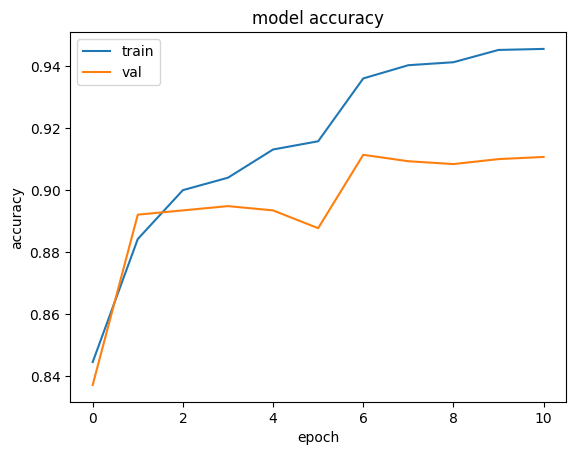

In [66]:
plt.plot(ft_history['accuracy'])
plt.plot(ft_history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step


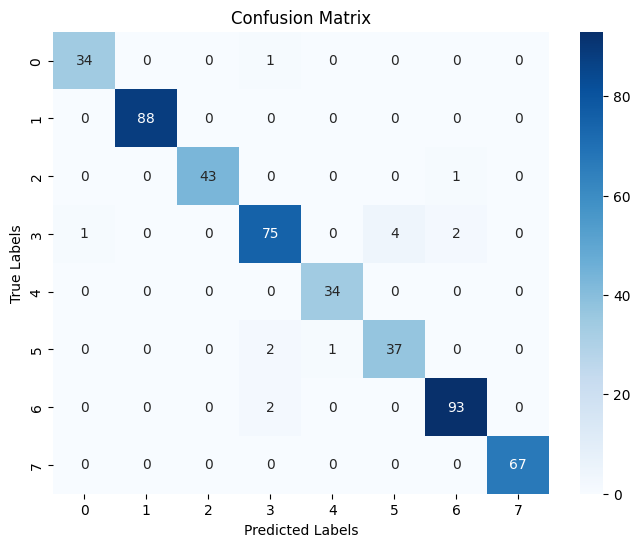

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        35
           1       1.00      1.00      1.00        88
           2       1.00      0.98      0.99        44
           3       0.94      0.91      0.93        82
           4       0.97      1.00      0.99        34
           5       0.90      0.93      0.91        40
           6       0.97      0.98      0.97        95
           7       1.00      1.00      1.00        67

    accuracy                           0.97       485
   macro avg       0.97      0.97      0.97       485
weighted avg       0.97      0.97      0.97       485



In [67]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predict on the test set
y_pred = gon_ft.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=np.arange(8), yticklabels=np.arange(8))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print(classification_report(y_true, y_pred_classes))

100%|██████████| 2/2 [00:24<00:00, 12.47s/it]


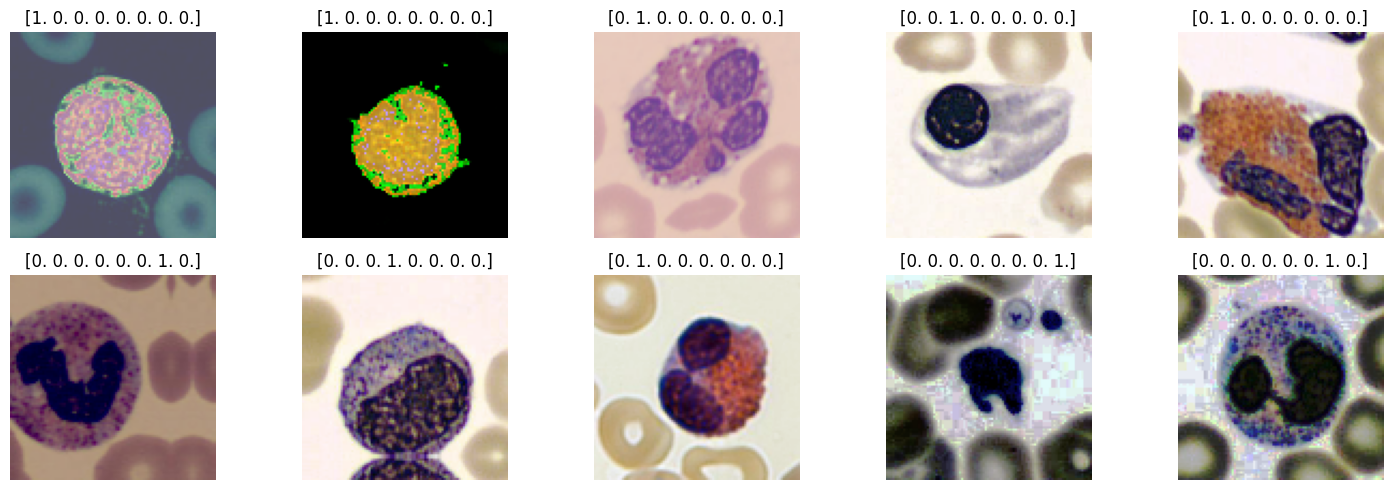

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step


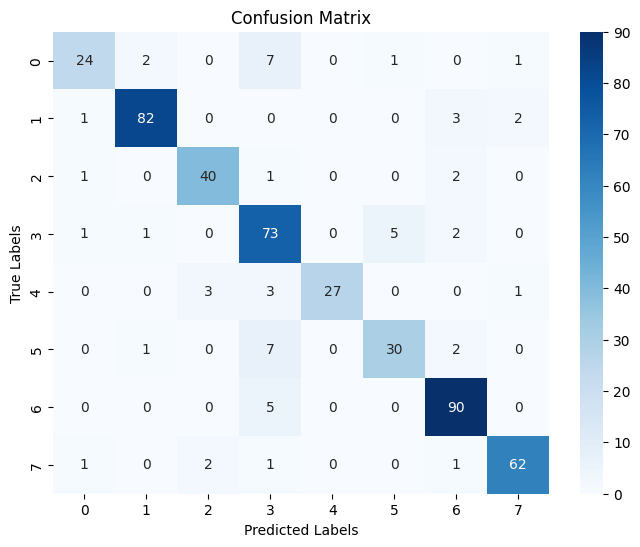

              precision    recall  f1-score   support

           0       0.86      0.69      0.76        35
           1       0.95      0.93      0.94        88
           2       0.89      0.91      0.90        44
           3       0.75      0.89      0.82        82
           4       1.00      0.79      0.89        34
           5       0.83      0.75      0.79        40
           6       0.90      0.95      0.92        95
           7       0.94      0.93      0.93        67

    accuracy                           0.88       485
   macro avg       0.89      0.85      0.87       485
weighted avg       0.89      0.88      0.88       485



In [69]:
rand_augment = kcvl.RandAugment(
        value_range=(0, 255),
        augmentations_per_image=5,
        magnitude=0.4,
        magnitude_stddev=0.4,
        rate=0.65
    )
X_test_aug = []
for i in tqdm( range(0, len(X_test), batch_size)):
    X_batch = X_test[i:i + batch_size]
    temp_images = rand_augment(X_batch).numpy()
    X_test_aug.append(temp_images)
X_test_aug = np.concatenate(X_test_aug, axis=0)

X_test_aug = np.clip(X_test_aug, 0, 255).astype(np.uint8)
show_random_samples(X_test_aug, y_test)


# Predict on the test set
y_pred = gon_ft.predict(X_test_aug)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=np.arange(8), yticklabels=np.arange(8))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print(classification_report(y_true, y_pred_classes))

In [71]:
# Save the  model
gon_ft.save('/kaggle/working/kite_ft.keras')